# Lid Driven Cavity

## Math Recap

How nabla and laplace exactly work on vector and scalarfields
(Taken from ChatGPT)
### 1. Scalar Field (f(x, y))
- **Gradient (∇f):**
  $$
  \nabla f = 
  \begin{bmatrix}
  \frac{\partial f}{\partial x} \\
  \frac{\partial f}{\partial y}
  \end{bmatrix}
  $$
  *Result:* A vector field showing the rate of change of $ f $ in the $ x $- and $ y $-directions.

- **Laplacian (∇²f):**
  $$
  \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
  $$
  *Result:* A scalar field showing the sum of the second derivatives of $ f $, representing diffusion or spreading.


### 2. Vector Field ($\mathbf{u} = [u_x(x, y), u_y(x, y)]$)
- **Divergence (∇·u):**
  $$
  \nabla \cdot \mathbf{u} = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}
  $$
  *Result:* A scalar field showing the rate of "outflow" or expansion of $ \mathbf{u} $.

- **Gradient (∇u):**
  $$
  \nabla \mathbf{u} =
  \begin{bmatrix}
  \frac{\partial u_x}{\partial x} & \frac{\partial u_x}{\partial y} \\
  \frac{\partial u_y}{\partial x} & \frac{\partial u_y}{\partial y}
  \end{bmatrix}
  $$
  *Result:* A 2x2 tensor showing all partial derivatives of $ \mathbf{u} $.

- **Laplacian (∇²u):**
  $$
  \nabla^2 \mathbf{u} =
  \begin{bmatrix}
  \nabla^2 u_x \\
  \nabla^2 u_y
  \end{bmatrix}
  $$
  *Result:* A vector field where the Laplacian is applied component-wise.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm

## Definitions

In [3]:
GRID_SIZE = (41,41)
DOMAIN_SIZE = (1,1) # m

rho = 1.0 # kg/m^3 Density
nu = 0.01 # m/s^2 Kinematic Viscosity (v -> nu)

ITERATIONS = 500
pressure_poisson_iterations = 50

h = (DOMAIN_SIZE[0] / GRID_SIZE[0])# m : size of one cell
delta_t = 0.001 # s

In [4]:
class BCType(Enum):
    DIRICHLET = 0
    NEUMANN = 1

class BCLocation(Enum):
    """
    Enum for defining the location where bc is applied
    by calling .value you can get the slice for the grid
    """
    TOP = (-1, slice(None))         # [0, :]
    BOTTOM = (0, slice(None))     # [-1, :]
    LEFT = (slice(None), 0)        # [:, 0]
    RIGHT = (slice(None), -1)      # [:, -1]
    
    # One row inside
    TOP_INSIDE = (-2, slice(None))        # [1,:]
    BOTTOM_INSIDE = (1, slice(None))    # [-2,:]
    LEFT_INSIDE = (slice(None), 1)       # [:, 1]
    RIGHT_INSIDE = (slice(None), -2)     # [:,-2]
    

    def inside(self):
        """
        Returns the row next to the boundary, that is inside the domain
        with .value you can get the slicing object

        Returns:
            BCLocation: The Location inside the domain next to the boundary
        """
        match self:
            case BCLocation.TOP:
                return BCLocation.TOP_INSIDE
            case BCLocation.BOTTOM:
                return BCLocation.BOTTOM_INSIDE
            case BCLocation.LEFT:
                return BCLocation.LEFT_INSIDE
            case BCLocation.RIGHT:
                return BCLocation.RIGHT_INSIDE 
            
        

class FluidProperty(Enum):
    VELOCITY = 0
    PRESSURE = 1

In [5]:
BCLocation.BOTTOM.inside().value

(1, slice(None, None, None))

## 0. Initialisierung am Rechengitter

In [6]:
class Grid():
    def __init__(self, 
                 grid_size: tuple[int, int], 
                 domain_size: tuple[int,int]):
        
        # dimensions
        self.grid_size = grid_size
        self.domain_size = domain_size
        
        # points along one coordinate axis (maybe dont need to save)
        self._x_points: np.ndarray
        self._y_points: np.ndarray
        
        # meshgrid coordinates
        self.x: np.ndarray
        self.y: np.ndarray
        
        # velocity
        self.ux: np.ndarray
        self.uy: np.ndarray
        
        # pressure
        self.p: np.ndarray
        
        self._initialize_mesh()
        
        
    def _initialize_mesh(self) -> None:
        """
        Initializes the mesh
        Coordinates x, y + Grids for pressure, velocity in x and y direction
        """
        self._x_points = np.linspace(0,self.domain_size[0], self.grid_size[0])
        self._y_points = np.linspace(0, self.domain_size[1], self.grid_size[1])
        
        self.x, self.y = np.meshgrid(self._x_points, self._y_points) 

        self.p = np.zeros(self.grid_size)
        self.ux = np.zeros(self.grid_size)
        self.uy = np.zeros(self.grid_size)
            
    
    def bc_enforce_pressure(self) -> None:
        """
        Enforces the pressure boundary conditions on the grid
        """
        self._bc_enforce(type=BCType.NEUMANN, 
                        location=[BCLocation.RIGHT, BCLocation.BOTTOM, BCLocation.LEFT], 
                        val=0,
                        fluid_property=FluidProperty.PRESSURE)
        
        self._bc_enforce(type=BCType.DIRICHLET, 
                        location=BCLocation.TOP, 
                        val=0,
                        fluid_property=FluidProperty.PRESSURE)  
        
        
    def bc_enforce_velocity(self) -> None:
        """
        Enforces the velocity boundary conditions on the grid
        """
        self._bc_enforce(type=BCType.DIRICHLET, 
                        location=[BCLocation.RIGHT, BCLocation.BOTTOM, BCLocation.LEFT], 
                        val=[0,0],
                        fluid_property=FluidProperty.VELOCITY)
        
        self._bc_enforce(type=BCType.DIRICHLET,
                        location=BCLocation.TOP,
                        val=[1,0],
                        fluid_property=FluidProperty.VELOCITY)
        
        
    def _bc_enforce(self,
                   type: BCType,
                   location: BCLocation | list[BCLocation], 
                   val: list[float,float] | float,
                   fluid_property: FluidProperty):
        """
        Enforces the boundary condition of the specified type at location on the Grid

        Args:
            type (BCType): The type of the boundary condition
            location (BCLocation): Where to apply bc, if a list then the same bc is applied to all locations in the list
            val (float): value to set the gradient to
            fluid_property (FluidProperty): Which property to enforce the boundary condition on
        """
        match type:
            case BCType.DIRICHLET:
                if isinstance(location, list):
                    for loc in location:
                        self._bc_dirichlet(loc, val, fluid_property)        
                else:
                    self._bc_dirichlet(location, val, fluid_property)
                
            case BCType.NEUMANN:
                if isinstance(location, list):
                    for loc in location:
                        self._bc_neumann_0(loc, fluid_property)
                else:
                    self._bc_neumann_0(location, fluid_property)
    
    def _bc_dirichlet(self,
                      location: BCLocation, 
                      val: list[float,float] | float, 
                      fluid_property: FluidProperty):
        """
        Enforces the boundary condition on the grid

        Args:
            location (BCLocation): Where to apply the boundary condition
            val (list[float,float] | float): what to set the boundary to. expects a vector for velocity and a float for pressure
            fluid_property (FluidProperty): Which property to enforce the boundary condition on
        """
        if fluid_property == FluidProperty.VELOCITY:
            assert isinstance(val, list)
            self.ux[location.value] = val[0]
            self.uy[location.value] = val[1]

        elif fluid_property == FluidProperty.PRESSURE:
            assert isinstance(val, (float, int))
            self.p[location.value] = val

            
    def _bc_neumann_0(self,
                    location: BCLocation,
                    fluid_property: FluidProperty) -> None:
        """
        Enforces the boundary condition on the grid
        Neumann boundary condition  = 0
        Gradient at the boundary set to 0 
        -> value on the boundary same as value just inside the boundary
        Args:
            location (BCLocation): Where to apply bc
            fluid_property (FluidProperty): Which property to enforce the boundary condition on
        """
        if fluid_property == FluidProperty.VELOCITY:
            self.ux[location.value] = self.ux[location.inside().value]
            self.uy[location.value] = self.uy[location.inside().value]

        elif fluid_property == FluidProperty.PRESSURE:
            self.p[location.value] = self.p[location.inside().value]
            
            
            
            
    def plot_everything(self, streamplot = False) -> None:
        plt.contourf(self.x, self.y, self.p, cmap="coolwarm")
        plt.colorbar()
        if not streamplot:
            plt.quiver(self.x, self.y, self.ux, self.uy)
        else:
            plt.streamplot(self.x, self.y, self.ux, self.uy)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title("Pressure & Velocity")
        plt.show()
        
        
    def plot_velocity(self, streamplot = False) -> None:
        if not streamplot:
            plt.quiver(self.x, self.y, self.ux, self.uy)
        else:
            plt.streamplot(self.x, self.y, self.ux, self.uy)        
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title("Velocity")
        plt.colorbar()
        plt.show()
        
    def plot_pressure(self) -> None:
        plt.contourf(self.x, self.y, self.p, cmap="coolwarm")
        plt.colorbar()
        plt.title("Pressure")
        plt.show()

In [7]:
def d_dx(grid: np.ndarray) -> np.ndarray:
    """
    central difference x for all points inside the domain (not calculated on boundaries)
    val right - left

    Args:
        grid (np.ndarray): the grid with values for that the central difference in x direction should be performed

    Returns:
        np.ndarray: grid of same size as input, containing the central difference in x direction for each cell in the input
    """
    central_diff_x = np.zeros_like(grid)
    central_diff_x[:, 1:-1] = (grid[:, 2:] - grid[:, :-2]) / (2*h)
    return central_diff_x

def d_dy(grid: np.ndarray) -> np.ndarray:
    """
    central difference y for all points inside the domain (not calculated on boundaries)
    val Bottom - Top

    Args:
        grid (np.ndarray): the grid with values for that the central difference in y direction should be performed

    Returns:
        np.ndarray: grid of same size as input, containing the central difference in y direction for each cell in the input
    """
    central_diff_y = np.zeros_like(grid)
    central_diff_y[1:-1, :] = (grid[2:,:] - grid[:-2,:]) / (2*h)
    return central_diff_y
    

def laplace(grid: np.ndarray) -> np.ndarray:
    """
    Laplace operator 
    applies the laplace operator to each cell inside the domain 
    (right + left + Bottom + Top - 4*center) / h^2

    Args:
        grid (np.ndarray): the grid where laplace should be applied

    Returns:
        np.ndarray: grid of same size as input, each cell containing the value obtained after applying the laplace operator to the input
    """
    lpc = np.zeros_like(grid)
    lpc[1:-1,1:-1] = (grid[1:-1, 2:] + grid[1:-1, :-2] + grid[2:,1:-1] + grid[:-2,1:-1] - 4*grid[1:-1,1:-1]) / (h**2)
    return lpc

### Test the d/dx, d/dy, laplace functions

In [8]:
example = np.linspace(0,1,11)**2
example = [list(example*n) for n in range(11)]
example = np.array(example)
example[0,:] = 1
example[:,-1] = 0
example[:,-0] = 0
example[-1,:] = 0
assert round((0.04-0) / (h*2), 2) == round(d_dx(example)[1,1], 2)
assert round((0.02-1) / (h*2),2) == round(d_dy(example)[1,1], 2)
assert round((0.04 + 1.0 + 0.0 + 0.02 -4*0.01)/(h**2),2) == round(laplace(example)[1,1],2)

# print(example)
# print("\nAt 1,1")
# print(f"x diff: {(0.04-0) / (h*2)}")
# print(f"x diff func: {d_dx(example)[1,1]}")
# print(f"y diff: {(0.02-1) / (h*2)}")
# print(f"y diff func: {d_dy(example)[1,1]}")
# print(f"laplace: {(0.04 + 1.0 + 0.0 + 0.02 -4*0.01)/(h**2)}")
# print(f"laplace func: {laplace(example)[1,1]}")
# print(d_dx(example))
# print(d_dy(example))
# print(laplace(example))


## 1. Impuls ohne Druckgradient

$$
\frac{\partial u}{\partial t} = \nu\nabla^2u -  (u * \nabla)u 
$$


1. for each point inside the domain (not on boundaries) calculate $\frac{\partial u}{\partial t}$ according to the equation above. That is u* not taking into account the pressure changes
2. Save the u* in a new grid 

For the $x$-component:
$$
\frac{\partial u_x}{\partial t} = \nu \left( \frac{\partial^2 u_x}{\partial x^2} + \frac{\partial^2 u_x}{\partial y^2} \right) - \left( u_x \frac{\partial u_x}{\partial x} + u_y \frac{\partial u_x}{\partial y} \right)
$$

For the $y$-component:
$$
\frac{\partial u_y}{\partial t} = \nu \left( \frac{\partial^2 u_y}{\partial x^2} + \frac{\partial^2 u_y}{\partial y^2} \right) - \left( u_x \frac{\partial u_y}{\partial x} + u_y \frac{\partial u_y}{\partial y} \right)
$$

Because the change of velocity calculated at 1. is in m/s, the actual adjustment in this iteration is the change times timestep length

In [11]:
def change_of_velocity_without_pressure(grid: Grid):
    """
    Calculate the impulse without pressure gradient as a tentative step

    """
    # difference of (x/y) velocity in x direction + difference of velocity in y direction 
    dux_dt = (nu*laplace(grid.ux) - (grid.ux*d_dx(grid.ux) + grid.uy*d_dy(grid.ux))) * delta_t
    duy_dt = (nu*laplace(grid.uy) - (grid.ux*d_dx(grid.uy) + grid.uy*d_dy(grid.uy))) * delta_t
    return dux_dt, duy_dt

2. Solve Pressure Poisson for next timestep

$$
\nabla^2 p = \frac{\rho}{\Delta t} * \nabla u
$$

3. Make Velocity Correction

$$
u \larr u - \frac{\Delta t}{ \rho} \nabla p
$$

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 990.96it/s] 


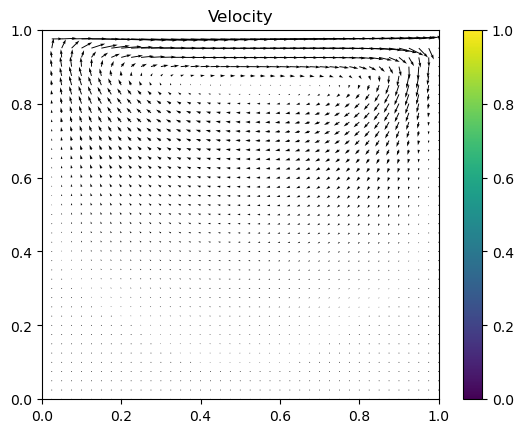

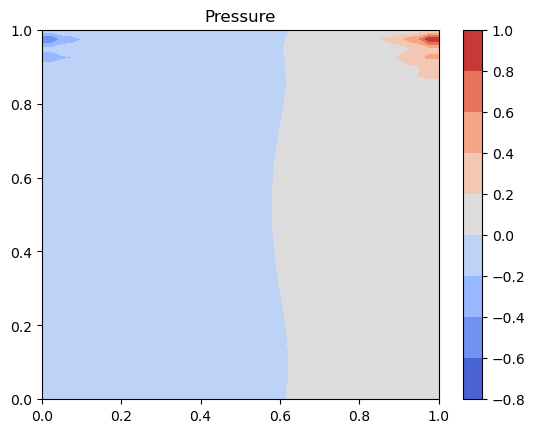

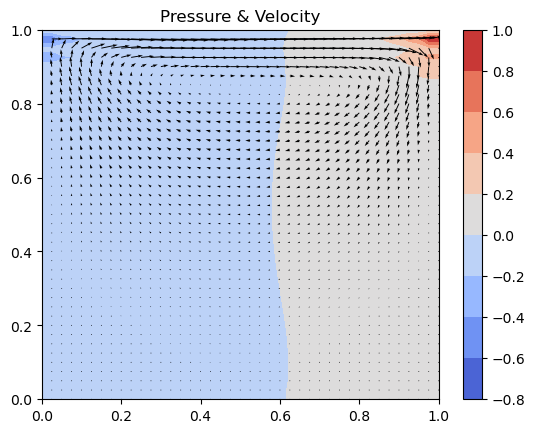

In [ ]:
# 0 Initialize Grids 
grid_0 = Grid(grid_size=GRID_SIZE, domain_size=DOMAIN_SIZE) # previous time step
grid_tent = Grid(grid_size=GRID_SIZE, domain_size=DOMAIN_SIZE) # tentative time step
grid_1 = Grid(grid_size=GRID_SIZE, domain_size=DOMAIN_SIZE) # next time step

# Set initial conditions
grid_0.bc_enforce_pressure()
grid_0.bc_enforce_velocity()


for _ in tqdm(range(ITERATIONS)):
    
    # 1 Momentum without pressure 
    # Calculate the tentative velocity before taking into account the pressure
    dux_dt, duy_dt = change_of_velocity_without_pressure(grid_0)
    grid_tent.ux = grid_0.ux + dux_dt 
    grid_tent.uy = grid_0.uy + duy_dt
    
    # 1.1 Enforce velocity boundary conditions
    grid_tent.bc_enforce_velocity()
    
    # 2.1 Solve RHS of the pressure poisson equation
    # rho/dt * nabla(u)
    rhs_ppe = (rho/delta_t) * (d_dx(grid_tent.ux) + d_dy(grid_tent.uy))
    
    # 2.2 Using the RHS to calculate the pressure in the PPE
    # Solve equation using jacobi method
    for i in range(pressure_poisson_iterations): # Or till smaller than Tol
        grid_1.p = np.zeros_like(grid_0.p)
        grid_1.p[1:-1,1:-1] = 0.25 * (grid_0.p[1:-1, 2:] + 
                                        grid_0.p[1:-1, :-2] + 
                                        grid_0.p[2:,1:-1] + 
                                        grid_0.p[:-2,1:-1] - h**2 * rhs_ppe[1:-1,1:-1])
        
        # 2.3 Enforce pressure boundary condition
        grid_1.bc_enforce_pressure()  
        grid_0.p = grid_1.p
        
    # 3.1 Correct the velocity with the pressure
    # u_t+1 = u_tent - (delta_t/rho) * nabla(p)
    grid_1.ux = grid_tent.ux - (delta_t/rho) * d_dx(grid_1.p)
    grid_1.uy = grid_tent.uy - (delta_t/rho) * d_dy(grid_1.p)

    # 3.2 Enforce velocity boundary conditions
    grid_1.bc_enforce_velocity()
    
    
    # 4 Update the grid for the next iteration
    grid_0.ux = grid_1.ux
    grid_0.uy = grid_1.uy
    grid_0.p = grid_1.p
    
    
    
grid_0.plot_velocity(streamplot=False)
grid_0.plot_pressure()
grid_0.plot_everything(streamplot=False)